### 作业16 

如果某质量为m的天体，从无穷远处到被黑洞吸积到最小稳定轨道（3Rs），释放的能量是多少?

$R_s = \frac{2GM}{c^2}$

无穷远处的能量：$E=mc^2$

在圆轨道$3R_s$处的能量为：？




如果一个星系中的AGN光度超过恒星光度，其黑洞质量与恒星质量的比值最低是多少？

$L_E \sim 30000 \times \frac{M_\text{BH}}{M_{\odot}}L_{\odot}$

$L_* = \frac{M_*}3\times L_\odot$

假设$L_{AGN}\approx L_{Edd} > L_*$

$30000\times \frac{M_\text{BH}}{M_{\odot}}L_\odot > \dfrac{M_*}{3}L_\odot$

得到$\frac{M_\text{BH}}{M_*}>\dfrac{1}{90000}$

### 作业17

对于作业5中的星系（或选择一个新的低红移星系），将其人为放置到更高红移处，生成在同样望远镜观测中的图像（可选多波段，并考虑K改正效应）。

从DESI EDR中选择了一个星系，且在COSMOS中：

"https://www.legacysurvey.org/viewer/cutout.fits?ra=150.2732&dec=1.7147&layer=ls-dr9&pixscale=0.262&size=128&invvar=True"


In [1]:
from astropy.io import fits
import pandas as pd
import numpy as np

红移直接从DESI viewer中的layer获取了，这里是查一下BGS catalog中的流量信息

In [2]:
with fits.open("/data1/public/BGS/BGS_BRIGHT_SOUTH.fits") as bgs_fits:
    columns = ["RA", "DEC", "FLUX_G", "FLUX_R", "FLUX_Z", "FLUX_IVAR_G", "FLUX_IVAR_R", "FLUX_IVAR_Z"]
    bgs_data = {col: np.array(bgs_fits[1].data[col], dtype='<f8') for col in columns}  # 转换为小端字节序
    bgs_df = pd.DataFrame(bgs_data, columns=columns)

In [3]:
# ra=150.2732 dec=1.7147
bgs_df.query("RA > 150.27 & RA < 150.28 & DEC > 1.71 & DEC < 1.72")

RA       DEC     FLUX_G     FLUX_R      FLUX_Z  FLUX_IVAR_G  \
6330554  150.27316  1.714656  22.280605  60.651527  120.280014   145.857697   

         FLUX_IVAR_R  FLUX_IVAR_Z  
6330554    10.646157     8.703979

读图展示

In [4]:
with fits.open("/data/public/renhaoye/ai4galmorph/homework/cutout_150.2732_1.7147.fits") as hdul:
    img = hdul[0].data
    ivar = hdul[1].data

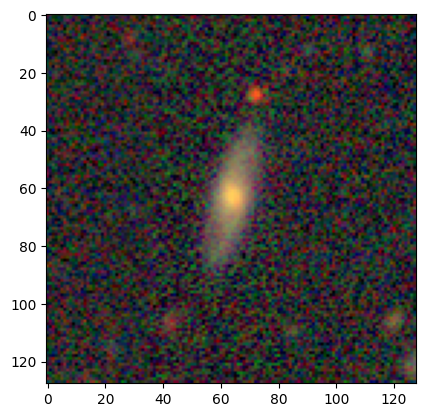

In [5]:
import matplotlib.pyplot as plt
def arcsinh_rgb(imgs, mode="CHW", m = 0.03, clip=True): # from DESI imagine
    scales = None
    bands = ["g", "r", "z"]
    rgbscales =dict(g=(2,6.0), r=(1,3.4), z=(0,2.2))

    I = 0
    for img,band in zip(imgs, bands):
        plane,scale = rgbscales[band]
        img = np.maximum(0, img * scale + m)
        I = I + img
    I /= len(bands)

    Q = 50
    fI = np.arcsinh(Q * I) / np.sqrt(Q)
    I += (I == 0.) * 1e-9
    H,W = I.shape
    if mode == "HWC":
        rgb = np.zeros((H,W,3), np.float32)
        for img,band in zip(imgs, bands):
            plane,scale = rgbscales[band]
            rgb[:,:,plane] = (img * scale + m) * fI / I
    elif mode == "CHW":
        rgb = np.zeros((3,H,W), np.float32)
        for img,band in zip(imgs, bands):
            plane,scale = rgbscales[band]
            rgb[plane] = (img * scale + m) * fI / I
    if clip:
        rgb = np.clip(rgb, 0, 1)
    return rgb

plt.imshow(arcsinh_rgb(img, mode="HWC"))
plt.show()


参考A&A 676, A74 (2023)中采用的Blanton & Roweis (2007)开发的python kcorrect包获取k改正大小

In [6]:
import kcorrect.kcorrect
responses = ['decam_g', 'decam_r', 'decam_z']
kc = kcorrect.kcorrect.Kcorrect(responses=responses)

redshift = 0.17
flux_g, flux_r, flux_z = 22.280605, 60.651527, 120.280014 # In nanomaggy
maggies = [flux_g*1e-9, flux_r*1e-9, flux_z*1e-9]
flux_ivar_g, flux_ivar_r, flux_ivar_z = 145.857697*1e8, 10.646157*1e8, 8.703979*1e8
ivar = [flux_ivar_g, flux_ivar_r, flux_ivar_z]

# "coeffs" is a [5]-array with coefficients multiplying each template
coeffs = kc.fit_coeffs(redshift=redshift, maggies=maggies, ivar=ivar)

# "k" is a [5]-array with the K-corrections in magnitude units
k = kc.kcorrect(redshift=redshift, coeffs=coeffs)

In [7]:
k

array([0.51718428, 0.18270797, 0.08438797])

改正到静止帧

In [8]:
def flux2mag(flux):
    return 22.5-2.5*np.log10(flux)
def mag2flux(mag):
    return 10**((22.5-mag)/2.5)
mag_g_c, mag_r_c, mag_z_c = flux2mag(flux_g)-k[0], flux2mag(flux_r)-k[1], flux2mag(flux_z)-k[2]
flux_g_c, flux_r_c, flux_z_c = mag2flux(mag_g_c), mag2flux(mag_r_c), mag2flux(mag_z_c)
flux_correct_g, flux_correct_r, flux_correct_z = flux_g_c/flux_g, flux_r_c/flux_r, flux_z_c/flux_z
flux_correct_g, flux_correct_r, flux_correct_z

(1.6101773481737063, 1.1832681839800545, 1.080824515731282)

查看静止帧的图像

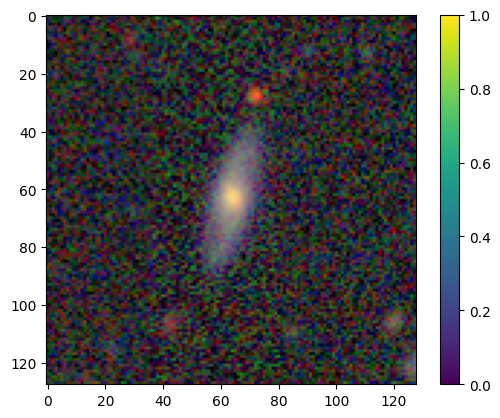

In [9]:
local_img = img * np.array([flux_correct_g, flux_correct_r, flux_correct_z])[:, np.newaxis, np.newaxis]
plt.imshow(arcsinh_rgb(local_img, mode="HWC"))
plt.colorbar()
plt.show()

根据cosmic dimming计算流量变化，将g波段红移到r波段，大概需要增加0.3的红移，采样了一样的拉伸，并展示了colorbar方便比较

简化了两个部分：背景没有根据pixel scale的变化重新采样，并直接计算了目标图像的pixel scale，而非真正的重采样。

5.819395908120373


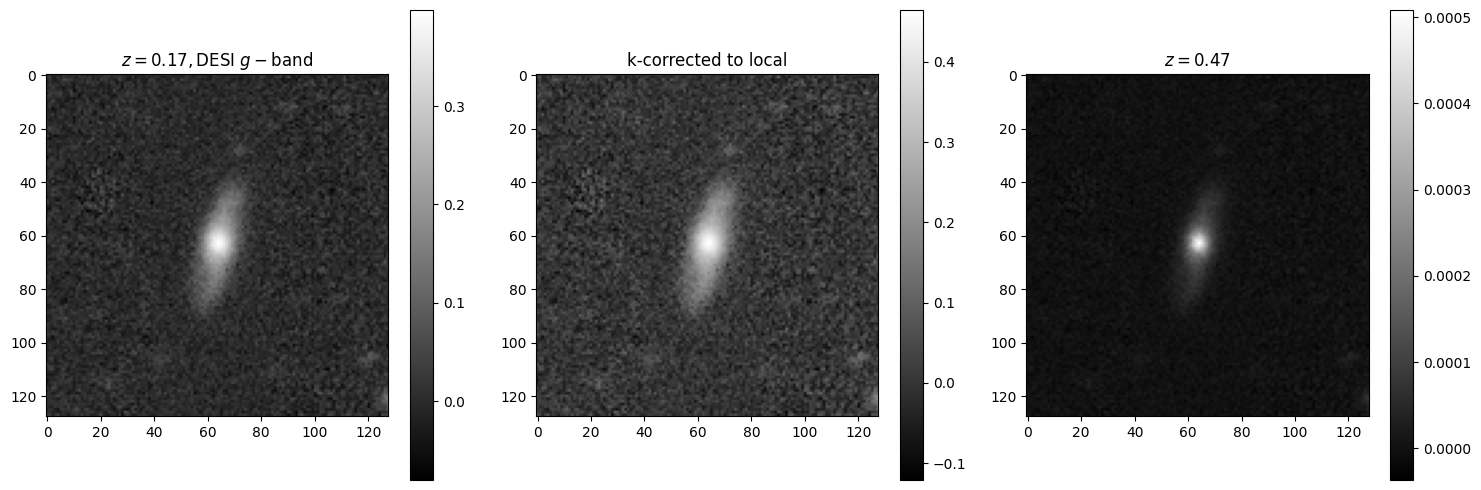

In [10]:
from astropy.cosmology import LambdaCDM
def flux_factor(z_add=0.9, H0=70, Om0=0.3, Ode0=0.7):
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=Ode0)
    z_high = z_add
    Dl_local = cosmo.luminosity_distance(0.01).value
    Dl_high = cosmo.luminosity_distance(z_high).value
    dimming_factor = (Dl_local / Dl_high)**2
    return dimming_factor
def ang_factor(z_add=0.9, H0=70, Om0=0.3, Ode0=0.7):
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=Ode0)
    z_high = z_add
    D_ang_local = cosmo.angular_diameter_distance(0.01).value
    D_ang = cosmo.angular_diameter_distance(z_high).value
    return D_ang/D_ang_local
plt.figure(figsize=(15,5))
redshifted = local_img[0]*flux_factor(0.17+0.3)
plt.subplot(131)
plt.imshow(np.arcsinh(img[0]*50)/np.sqrt(50), cmap="gray")
plt.title(r"$z=0.17, \text{DESI }g-\text{band}$")
plt.colorbar()
plt.subplot(132)
plt.imshow(np.arcsinh(local_img[0]*50)/np.sqrt(50), cmap="gray")
plt.title("k-corrected to local")
plt.colorbar()
plt.subplot(133)
plt.imshow(np.arcsinh(redshifted*50)/np.sqrt(50), cmap="gray")
pixel_size = 0.262*ang_factor(0.01+0.3)
print(pixel_size)
plt.title(r"$z=0.47$")
plt.colorbar()
plt.tight_layout()
plt.show()

### 作业18

对于作业5或者作业15中的星系，采取至少一种方法来（定量）评估该星系所处的环境。

对上面放红移的这个星系，下载Darvish et al. (2017) ApJ 837:16的catalog描述宇宙大尺度catalog

In [11]:
from astropy.io import ascii
data = ascii.read('environment-cosmicweb-table2.tbl')
df = data.to_pandas()

In [12]:
df.query("ra == 150.273161 & dec == 1.705707")

id          ra       dec  photo_z  density  overdensity  S_cluster  \
69383  276210  150.273161  1.705707   0.3118     0.71         0.28        0.0   

       S_filament environment  flag  
69383    0.028287    filament     0

In [ ]:
#good,就是有点偷懒

其环境为filament，所处环境密度为$0.71Mpc^{-2}$, 相比该星系红移的中位数密度，其密度偏低，密度/中位数密度=0.28